# Tensorflow Dataset 相關用法整理

## 程式參考來源：
- https://www.tensorflow.org/guide/data
- https://www.tensorflow.org/guide/data_performance
- https://www.tensorflow.org/tutorials/keras/text_classification

## 建立方式

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


## List 轉 Dataset

使用 from_tensor_slices 函數，自陣列建立 Dataset

In [2]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [3]:
# numpy()：TF Tensor 轉 NumPy 陣列(Array)
for elem in dataset:
    print(elem.numpy())

8
3
0
8
2
1


In [4]:
# iterator
it = iter(dataset)
# 一次取一筆
print(next(it).numpy())
print(next(it).numpy())

8
3


## tf.data.Dataset.reduce()：Return combined single result after transformation.
### print(dataset.reduce(axis, lambda state, value: state + value).numpy())
### state：目前狀態(累計結果)，value: 元素值

In [5]:
# 求總和
gfg = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5]) 

# 0: 初始值
print(gfg.reduce(0, lambda x, y: x + y).numpy()) 


15


In [6]:
# 小計
gfg = tf.data.Dataset.from_tensor_slices([[5, 10], [3, 6]]) 
  
# 0: 初始值 0，沿著列作行的小計
print(gfg.reduce(0, lambda x, y: x + y).numpy()) 

[ 8 16]


In [7]:
# 小計
gfg = tf.data.Dataset.from_tensor_slices([[5, 10], [3, 6]]) 
  
# 1: 初始值 1，沿著列作行的小計
print(gfg.reduce(1, lambda x, y: x + y).numpy()) 

[ 9 17]


In [8]:
# 相乘
gfg = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5]) 
# 0: 初始值
print(gfg.reduce(0, lambda x, y: x * y).numpy()) 


0


In [9]:
# 相乘
gfg = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5]) 
# 1: 初始值
print(gfg.reduce(1, lambda x, y: x * y).numpy()) 


120


In [10]:
# 相乘
gfg = tf.data.Dataset.from_tensor_slices([[5, 10], [3, 6]]) 
# 0: 初始值 0，沿著列作行的小計  
print(gfg.reduce(0, lambda x, y: x * y).numpy()) 

[0 0]


In [11]:
# 相乘
gfg = tf.data.Dataset.from_tensor_slices([[5, 10], [3, 6]]) 
 # 1: 初始值 1，沿著列作行的小計  
print(gfg.reduce(1, lambda x, y: x * y).numpy()) 

[15 60]


## Map/Filter

In [12]:
# Map
gfg = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5]) 

for elem in gfg.map(lambda x: x * 2):
    print(elem.numpy())

Cause: could not parse the source code:

for elem in gfg.map(lambda x: x * 2):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

for elem in gfg.map(lambda x: x * 2):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2
4
6
8
10


In [13]:
# Filter
gfg = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5]) 

filter = lambda x: x % 2 == 0
for elem in gfg.filter(filter):
    print(elem.numpy())

2
4


## 結合 Python generator
搭配repeat、batch、skip、take...等函數

In [14]:
def count(stop):
    i = 0
    while i<stop:
        yield i
        i += 1

# args=[25] ： 最多從 count 函數取25個    
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )
# repeat()：取完會重頭再開始
# batch(10)：一次取 10 個
# take(5)：取 5 次
for count_batch in ds_counter.repeat().batch(10).take(5):
    print(count_batch.numpy())


[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


# 每批取不定個數

In [15]:
def gen_series():
    i = 0
    while True:
        size = np.random.randint(0, 10)
        yield i, np.random.normal(size=(size,))
        i += 1
        
for i, series in gen_series():
    print(i, ":", str(series))
    if i > 5:
        break        

0 : [ 1.75729081  0.28911147  0.84377282  0.67568385 -0.99291125  0.45465562]
1 : [-0.55623477 -1.26550744 -1.43995885]
2 : [-3.01925413e-01  9.30215757e-02 -1.04043443e-03  4.86759717e-01
  2.37744392e+00 -1.01613174e+00  3.89378785e-01]
3 : [-0.86726408 -1.56151633  0.84805742]
4 : [-0.0749907   0.52709337 -0.2307324  -0.62256313  0.25239583 -0.47842326
 -1.87651888 -0.04319887]
5 : []
6 : []


## 洗牌(shuffle)

In [16]:
def count(stop):
    i = 0
    while i<stop:
        yield i
        i += 1

# args=[25] ： 最多從 count 函數取25個    
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )

# 一次取 20 個洗牌，取完，再抽 20 個洗牌
# batch(10)：一次取 10 個
# take(5)：取 5 次
for count_batch in ds_counter.shuffle(20).batch(10).take(5):
    print(count_batch.numpy())

[ 2 12 19 13  4  5 22 18 24 10]
[ 3  0 16  8 11  6 14 23  7 15]
[21  1  9 17 20]


## 從網址取得壓縮檔，解壓縮，並作資料增補後，讀取影像

- tf.keras.utils.get_file：從網址取得壓縮檔，untar=True：解壓縮
- ImageDataGenerator：讀取影像，可同時作特徵縮放、資料增補(Data Augmentation)...。

Found 402 images belonging to 1 classes.


array([1.], dtype=float32)

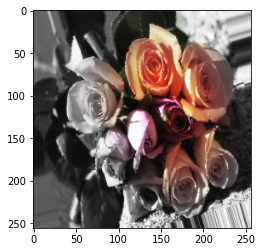

In [17]:
# 下載檔案
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

# rescale：特徵縮放
# rotation_range：自動增補旋轉20度內的圖片
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

images, labels = next(img_gen.flow_from_directory(flowers))

import matplotlib.pyplot as plt
plt.imshow(images[0])
labels[0]

## 從目錄取得影像

In [20]:
ds = tf.data.Dataset.from_generator(
    img_gen.flow_from_directory, args=[flowers], 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,256,256,3], [32,5])
)

ds

<FlatMapDataset shapes: ((32, 256, 256, 3), (32, 5)), types: (tf.float32, tf.float32)>

## 結合 TFRecord
TFRecord 是一個簡單的資料列導向的儲存體(record-oriented binary format)，它可以儲存不同格式的資料。

In [21]:
# TFRecord file format is a simple record-oriented binary format
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

fsns_test_file

7905280/7904079 [==============================] - 1s 0us/step


'C:\\Users\\Chiawei_Chuang\\.keras\\datasets\\fsns.tfrec'

In [22]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [23]:
# Many TensorFlow projects use serialized tf.train.Example records in their TFRecord files. 
# These need to be decoded before they can be inspected:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())
parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

## 結合 Text

In [24]:
# 讀取三個檔案
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url + file_name)
    for file_name in file_names
]

811008/807992 [==============================] - 0s 0us/step


In [25]:
# 合併多個檔案為一資料集
dataset = tf.data.TextLineDataset(file_paths)
# 讀取5行資料
for line in dataset.take(5):
    print(line.numpy())

b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b'His wrath pernicious, who ten thousand woes'
b"Caused to Achaia's host, sent many a soul"
b'Illustrious into Ades premature,'
b'And Heroes gave (so stood the will of Jove)'


In [26]:
# interleave：每個檔案輪流取一次
files_ds = tf.data.Dataset.from_tensor_slices(file_paths)
lines_ds = files_ds.interleave(tf.data.TextLineDataset, cycle_length=3)

for i, line in enumerate(lines_ds.take(9)):
    if i % 3 == 0:
        print()
    print(line.numpy())


b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b"\xef\xbb\xbfOf Peleus' son, Achilles, sing, O Muse,"
b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought'

b'His wrath pernicious, who ten thousand woes'
b'The vengeance, deep and deadly; whence to Greece'
b'countless ills upon the Achaeans. Many a brave soul did it send'

b"Caused to Achaia's host, sent many a soul"
b'Unnumbered ills arose; which many a soul'
b'hurrying down to Hades, and many a hero did it yield a prey to dogs and'


In [27]:
# 篩選資料列
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

# 取10筆資料
for line in titanic_lines.take(10):
    print(line.numpy())

32768/30874 [===============================] - 0s 1us/step
b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'
b'0,male,22.0,1,0,7.25,Third,unknown,Southampton,n'
b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y'
b'0,male,2.0,3,1,21.075,Third,unknown,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'


In [28]:
# 只取生存者的資料10筆
def survived(line):
    return tf.not_equal(tf.strings.substr(line, 0, 1), "0")

survivors = titanic_lines.skip(1).filter(survived)
for line in survivors.take(10):
    print(line.numpy())

b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'
b'1,male,28.0,0,0,13.0,Second,unknown,Southampton,y'
b'1,female,28.0,0,0,7.225,Third,unknown,Cherbourg,y'
b'1,male,28.0,0,0,35.5,First,A,Southampton,y'
b'1,female,38.0,1,5,31.3875,Third,unknown,Southampton,n'


## 結合 DataFrame

In [29]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
df = pd.read_csv(titanic_file, index_col=None)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [30]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
    for key, value in feature_batch.items():
        print("  {!r:20s}: {}".format(key, value))

  'survived'          : 0
  'sex'               : b'male'
  'age'               : 22.0
  'n_siblings_spouses': 1
  'parch'             : 0
  'fare'              : 7.25
  'class'             : b'Third'
  'deck'              : b'unknown'
  'embark_town'       : b'Southampton'
  'alone'             : b'n'


## 分離 Label、Features

In [31]:
# 註明 Label 欄位為 survived
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived")

In [32]:
for feature_batch, label_batch in titanic_batches.take(1):
    print("'survived': {}".format(label_batch))
    print("features:")
    for key, value in feature_batch.items():
        print("    {!r:20s}: {}".format(key, value))

'survived': [0 0 1 0]
features:
    'sex'               : [b'female' b'male' b'male' b'male']
    'age'               : [28. 50. 32. 28.]
    'n_siblings_spouses': [0 1 0 0]
    'parch'             : [0 0 0 0]
    'fare'              : [  7.75   106.425    7.8542  14.5   ]
    'class'             : [b'Third' b'First' b'Third' b'Third']
    'deck'              : [b'unknown' b'C' b'unknown' b'unknown']
    'embark_town'       : [b'Queenstown' b'Cherbourg' b'Southampton' b'Southampton']
    'alone'             : [b'y' b'n' b'y' b'y']


## 選擇部份欄位

In [33]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived", select_columns=['class', 'fare', 'survived'])

In [34]:
for feature_batch, label_batch in titanic_batches.take(1):
    print("'survived': {}".format(label_batch))
    print("features:")
    for key, value in feature_batch.items():
        print("    {!r:20s}: {}".format(key, value))

'survived': [0 0 0 1]
features:
    'fare'              : [31.275  19.9667 25.4667 24.15  ]
    'class'             : [b'Third' b'Third' b'Third' b'Third']


## 效能
https://www.tensorflow.org/guide/data_performance

- cache()：可將讀出得資料留在快取記憶體，已被之後重複使用。
- prefetch()：在訓練時，同時讀取下一批資料，並作轉換。


## 不使用 prefetch 

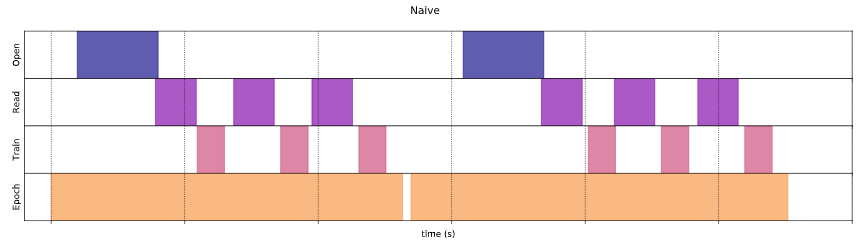

In [35]:
from IPython.display import Image
Image('./0_images/TF.Dataset Naive.png', width=500)

## 使用 prefetch，前置處理與訓練平行處理 

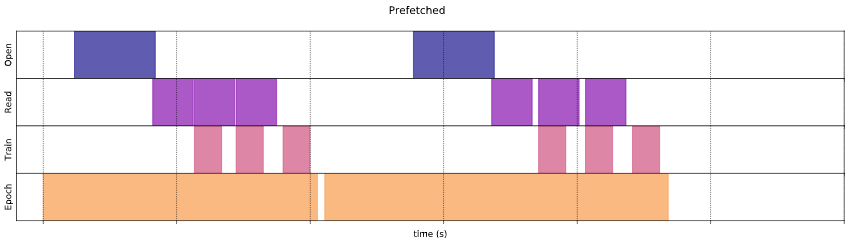

In [36]:
from IPython.display import Image
Image('./0_images/TF.Dataset prefetch.png', width=500)

## 使用 cache，硬碟I/O少很多

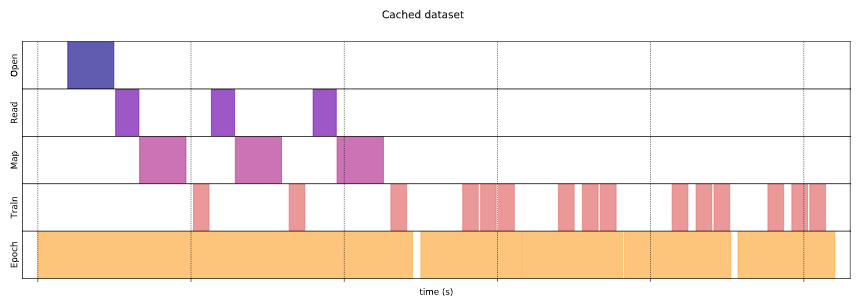

In [37]:
from IPython.display import Image
Image('./0_images/TF.Dataset cache.png', width=500)